In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
%matplotlib inline

# Patch Extraction Example  
I use blob detection to extract the dotted-area in the image

In [5]:
# data initialization
file_names = ['0.jpg']
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]
coordinates_df = pd.DataFrame(index=file_names, columns=classes)

In [7]:
# get coordinates
for filename in file_names:

    # read the Train and Train Dotted images
    image_1 = cv2.imread("./data/train-dotted/" + filename)
    image_2 = cv2.imread("./data/train/" + filename)

    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)

    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255

    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255

    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 

    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)

    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)

    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        g,b,r = image_1[int(y)][int(x)][:]

        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))

    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups

In [27]:
# extract 50 x 50 patches
x = []
y = []
for filename in file_names:    
    image = cv2.imread("./data/train/" + filename)
    for lion_class in classes:
        for coordinates in coordinates_df[lion_class][filename]:
            thumb = image[coordinates[1]-25:coordinates[1]+25,coordinates[0]-25:coordinates[0]+25,:]
            if np.shape(thumb) == (50, 50, 3):
                x.append(thumb)
                y.append(lion_class)
x = np.array(x)
y = np.array(y)

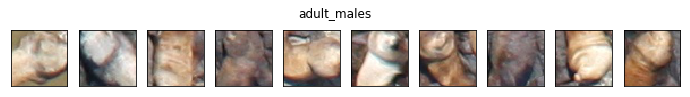

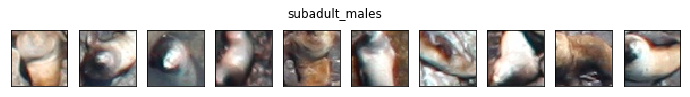

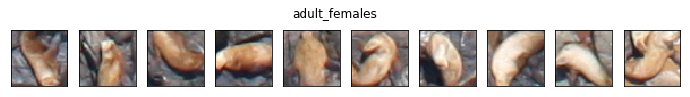

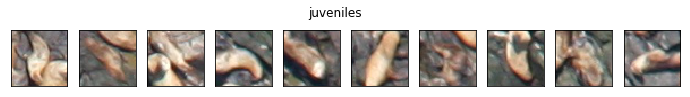

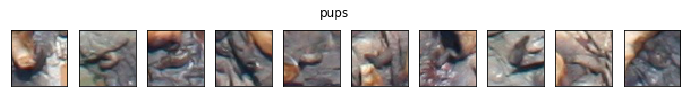

In [28]:
# plot examples
for lion_class in classes:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break

# Use Keras to train from a single image

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils

Using Theano backend.


In [29]:
encoder = LabelBinarizer()
encoder.fit(y)
y = encoder.transform(y).astype(float)

In [26]:
x = x/255-0.5

In [30]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(50,50,3),output_shape=(50,50,3)))

model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
history = model.fit(x, y, epochs=20, validation_split=0.2, verbose=1)

Train on 752 samples, validate on 188 samples
Epoch 1/20
752/752 [==============================] - 9s 12ms/step - loss: 1.0293 - acc: 0.6742 - val_loss: 0.3694 - val_acc: 0.9255
Epoch 2/20
752/752 [==============================] - 9s 12ms/step - loss: 0.5775 - acc: 0.8245 - val_loss: 0.1677 - val_acc: 0.9840
Epoch 3/20
752/752 [==============================] - 9s 12ms/step - loss: 0.4210 - acc: 0.8497 - val_loss: 0.0588 - val_acc: 0.9947
Epoch 4/20
752/752 [==============================] - 9s 12ms/step - loss: 0.3168 - acc: 0.8803 - val_loss: 0.0776 - val_acc: 0.9840
Epoch 5/20
752/752 [==============================] - 9s 12ms/step - loss: 0.2563 - acc: 0.9162 - val_loss: 0.1179 - val_acc: 0.9787
Epoch 6/20
752/752 [==============================] - 11s 15ms/step - loss: 0.1574 - acc: 0.9481 - val_loss: 0.0804 - val_acc: 0.9840
Epoch 7/20
752/752 [==============================] - 9s 12ms/step - loss: 0.1202 - acc: 0.9654 - val_loss: 0.0466 - val_acc: 0.9947
Epoch 8/20
752/752 [==

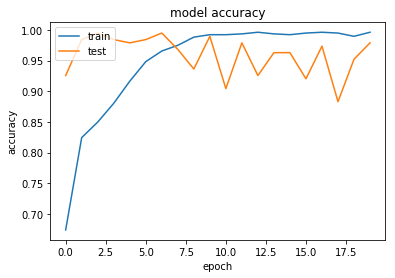

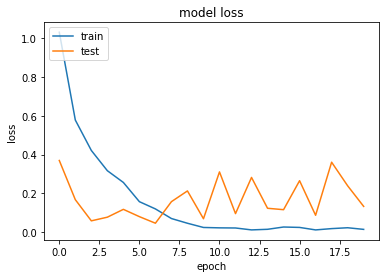

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()